# Solving the Soft Margin SVM Problem using Gradient Descent

**EE514: Data Analysis and Machine Learning**

[Kevin McGuinness](http://www.eeng.dcu.ie/~mcguinne/), School of Electronic Engineering, Dublin City University

---

Here we show how gradient descent can be used to solve the soft margin linear SVM problem. The stochastic version of this algorithm, where the gradient is estimated on a single sample or small batch of samples, is known as [Pegasos](http://www.ee.oulu.fi/research/imag/courses/Vedaldi/ShalevSiSr07.pdf) in the literature.

## Import packages and define some utility functions

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def load_dataset(fn):
    data = np.load(fn)
    return data['X'], data['y']

def plot_dataset(X, y):
    figure(figsize=(8,6))
    positives = X[y==1]
    negatives = X[y==-1]
    scatter(positives[:,0], positives[:,1], s=100, c='b', marker='*', label='positives')
    scatter(negatives[:,0], negatives[:,1], s=60, c='r', marker='^', label='negatives')
    legend()
    show()
    
def plot_decision_function(df, X, y):
    
    # Find span of data
    x0_min, x1_min = np.min(X, axis=0)
    x0_max, x1_max = np.max(X, axis=0)
    x0_range = x0_max - x0_min
    x1_range = x1_max - x1_min
    
    # Add small buffer around data
    x0_min = x0_min - 0.1 * x0_range
    x0_max = x0_max + 0.1 * x0_range
    x1_min = x1_min - 0.1 * x1_range
    x1_max = x1_max + 0.1 * x1_range
    
    # Generate linearly spaced points
    x0 = np.linspace(x0_min, x0_max, 100)
    x1 = np.linspace(x1_min, x1_max, 100)
    
    # Generate meshgrid
    X0, X1 = np.meshgrid(x0, x1)
    
    # Evaluate decision function for all points on the grid
    Y = df(np.c_[X0.ravel(), X1.ravel()]).reshape(X0.shape)
    
    # Plot the decision function
    figure(figsize=(8,6))
    contour(X0, X1, Y, levels=[-1,0,1], 
            linestyles=['dashed', 'solid', 'dashed'],
            linewidths=1,
            colors='k')
    
    # Plot the data
    positives = X[y==1]
    negatives = X[y==-1]
    scatter(positives[:,0], positives[:,1], s=100, c='b', marker='*', label='positives')
    scatter(negatives[:,0], negatives[:,1], s=60, c='r', marker='^', label='negatives')
    legend()
    show()

## Load the separable dataset

First we download a pre-made linearly separable dataset.

In [ ]:
!curl -O# http://www.eeng.dcu.ie/~mcguinne/data/ee514/separable.npz

######################################################################## 100.0%


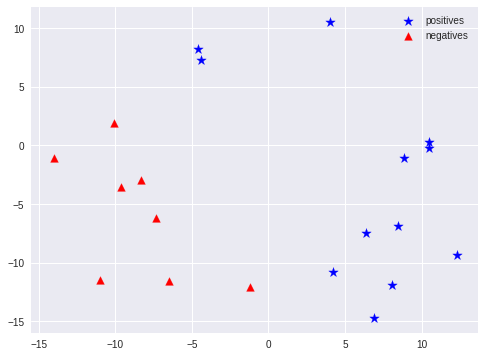

In [ ]:
X, y = load_dataset('separable.npz')
plot_dataset(X, y)

## SVM functions

The following functions implement the SVM
- decision function;
- prediction function (thresholded decision function);
- hinge loss function;
- and loss derivative function (needed for gradient descent).

We also define some functions for measuring error/accuracy.

In [ ]:
def svm_decision_function(X, w, b):
    return dot(X, w) + b

def svm_predict(X, w, b):
    return np.where(svm_decision_function(X, w, b) > 0, 1, -1)

def svm_loss(X, y, w, b, C):
    p = svm_decision_function(X, w, b)
    return 0.5 * np.dot(w, w) + C * np.maximum(1.0 - y * p, 0).sum()

def svm_accuracy(X, y, w, b):
    return (svm_predict(X, w, b) == y).mean()

def svm_error(X, y, w, b):
    return 1 - svm_accuracy(X, y, w, b)

def svm_dloss(X, y, w, b, C):
    margin = y * svm_decision_function(X, w, b)
    X_active = X[margin < 1, :]
    y_active = y[margin < 1]
    dw = w - C * (y_active[:,np.newaxis] * X_active).sum(axis=0)
    db = (-C) * y_active.sum(axis=0)
    return dw, db

## Gradient descent implementation

Here we implement a standard gradient descent loop with a fixed learning rate $\alpha$.


In [ ]:
def svm_solve_gradient_descent(X, y, C=1.0, alpha=1e-3, eps=1e-5, max_iter=1000):
    
    # Start with zero w, b
    w = np.zeros(X.shape[1])
    b = 0
    
    # Compute loss
    loss = svm_loss(X, y, w, b, C)
    
    print('Initial loss:', loss)
    
    # Repeat until converged
    for i in range(max_iter):
        
        # Save previous loss
        previous_loss = loss
        
        # Compute gradient of loss function
        dw, db = svm_dloss(X, y, w, b, C)
        
        # Update w and b
        w = w - alpha * dw
        b = b - alpha * db
        
        # Compute new loss
        loss = svm_loss(X, y, w, b, C)
        if i % 100 == 0:
            print('loss at epoch', i, '=', loss)
        
        # Check for convergence
        if abs(loss - previous_loss) < eps:
            break
        
            
    print('Final loss:', loss, 'after', i+1, 'iterations')
    
    return w, b, loss

## Solve the separable problem with gradient descent

In [ ]:
w, b, loss = svm_solve_gradient_descent(X, y)

Initial loss: 20.0
loss at epoch 0 = 5.029113587796132
loss at epoch 100 = 3.09083782869453
loss at epoch 200 = 2.087700819184355
loss at epoch 300 = 0.9451375123586714
loss at epoch 400 = 0.2373882337206015
loss at epoch 500 = 0.07350589214056348
loss at epoch 600 = 0.0809199913182038
Final loss: 0.0708702949430493 after 651 iterations


The decision boundary looks almost identical to the one found by CVXOPT in the [previous notebook](https://colab.research.google.com/drive/1-SzF8gkv3MAVCVmSsmuD2oxRyWr8Njsi).

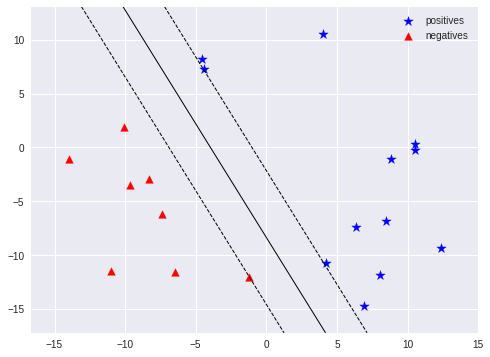

In [ ]:
df = lambda X: svm_decision_function(X, w, b)
plot_decision_function(df, X, y)

And, of course, since the problem is separable, the training error should be zero.

In [ ]:
print('Error:', svm_error(X, y, w, b))

Error: 0.0


## Exercises

- Try out the above algorithm on the non-separable problem.
- Test out different values for $C$ and see how this effects the decision boundary and training accuracy

In [ ]:
!curl -O# http://www.eeng.dcu.ie/~mcguinne/data/ee514/nonseparable.npz

######################################################################## 100.0%


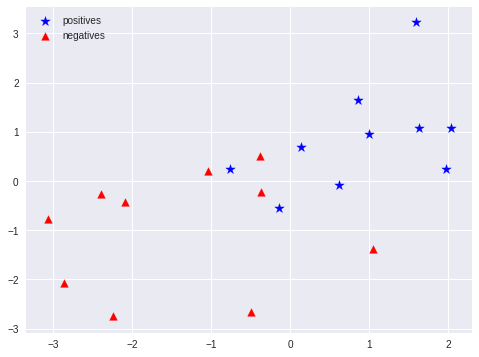

In [ ]:
X, y = load_dataset('nonseparable.npz')
plot_dataset(X, y)

In [ ]:
# ...